In [ ]:
!pip install -q -U keras-tuner
import kerastuner as kt

     |████████████████████████████████| 133 kB 5.4 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot
import math
from sklearn.impute import SimpleImputer
from pandas.plotting import scatter_matrix
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# main data
df = pd.read_csv('/content/drive/My Drive/thesis data/churn-data_11_DFS_trans_only_pearsons-selected.csv')
data = df.drop(df.columns[0:2,], axis=1)
print(data.shape)

(90692, 380)


In [ ]:
# selected columns from backward
data = data[['phones_used',
'handset_age',
'cred_score',
'cred_score + phones_used',
'COSINE(handset_price)',
'COSINE(user_months)',
'CUM_MAX(handset_age)',
'CUM_MEAN(cred_score)',
'CUM_MEAN(handset_price)',
'CUM_MEAN(phones_used)',
'CUM_SUM(cred_score)',
'1 / user_months',
'cred_score / phones_used',
'cred_score / user_months',
'handset_age / handset_price',
'handset_price / user_months',
'phones_used / user_months',
'user_months / handset_price',
'cred_score % phones_used',
'user_months % handset_price',
'cred_score * handset_price',
'cred_score * user_months',
'handset_age * handset_price',
'handset_price * phones_used',
'handset_price * user_months',
'phones_used * user_months',
'SINE(handset_price)',
'SINE(user_months)',
'TANGENT(handset_price)',
'TANGENT(user_months)',
'area_ATLANTIC SOUTH AREA',
'area_CENTRAL/SOUTH TEXAS AREA',
'area_DALLAS AREA',
'area_DC/MARYLAND/VIRGINIA AREA',
'area_GREAT LAKES AREA',
'area_HOUSTON AREA',
'area_MIDWEST AREA',
'area_NORTHWEST/ROCKY MOUNTAIN AREA',
'area_OHIO AREA',
'area_TENNESSEE AREA',
'dualband_N',
'web_capable_UNKOWN',
'web_capable_WCMB',
'manual_limit_False',
'PRIZM_code_C',
'PRIZM_code_R',
'PRIZM_code_S',
'PRIZM_code_U',
'credit_card_False',
'cred_score = manual_limit_False',
'cred_score = phones_used_False',
'credit_card = phones_used_False',
'phones_used > cred_score_False',
'user_months > phones_used_False',
'handset_age > 0_False',
'churn']]

In [ ]:
df.head(3)

,Unnamed: 0,Customer_ID,user_months,phones_used,handset_price,handset_age,cred_score,cred_score + phones_used,COSINE(handset_age),COSINE(handset_price),...,dualband != None_True,handset_age != None_True,handset_price != None_True,manual_limit != None_True,new_user != None_True,phones_used != None_True,refurb_or_new != None_True,user_months != None_True,web_capable != None_True,churn
0,0,1096894,0.114754,0.071429,0.24,0.002194,0.0,0.071429,-0.653644,0.834519,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
1,1,1082855,0.147541,0.178571,0.16,0.000000,0.0,0.178571,1.000000,-0.113145,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
2,2,1026564,0.426230,0.107143,0.16,0.000000,0.0,0.107143,1.000000,-0.113145,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1


In [ ]:
data.shape

(90692, 56)

In [ ]:
data[data.columns[data.isnull().any()]].isnull().sum() * 100 / data.shape[0]

Series([], dtype: float64)

In [ ]:
# sample for parameter search
data = data.sample(frac =.1)
data.shape

(9069, 56)

In [ ]:
# Data split
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['churn'], axis=1),
    data['churn'],
    test_size=0.1,
    random_state=63)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8162, 55), (907, 55), (8162,), (907,))

In [ ]:
def build_model(hp):
  model= keras.models.Sequential()

  model.add(Dense(hp.Int("input_units",
                         min_value=55,
                         max_value=55,
                         step=1), input_dim=55, activation='relu')) # input layer

  for i in range(hp.Int("n_layers", 1, 5)): # hidden layers
    model.add(Dense(hp.Int(f"dense_{i}_units",
                         min_value=1,
                         max_value=64,
                         step=8), activation = 'relu'))

  model.add(Dense(1)) # output layer

  model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

  return model

In [ ]:
tuner = kt.tuners.RandomSearch(build_model,
                               objective = "val_accuracy",
                               max_trials = 50, # 100
                               overwrite=True)

tuner.search(x=X_train,
             y=y_train,
             epochs=100, # 100
             validation_data=(X_test,y_test))

Trial 50 Complete [00h 01m 21s]
val_accuracy: 0.5854465365409851

Best val_accuracy So Far: 0.615215003490448
Total elapsed time: 01h 08m 43s
INFO:tensorflow:Oracle triggered exit


In [ ]:
data = df.drop(df.columns[0:2,], axis=1)
print(data.shape)
# selected columns from backward
data = data[['phones_used',
'handset_age',
'cred_score',
'cred_score + phones_used',
'COSINE(handset_price)',
'COSINE(user_months)',
'CUM_MAX(handset_age)',
'CUM_MEAN(cred_score)',
'CUM_MEAN(handset_price)',
'CUM_MEAN(phones_used)',
'CUM_SUM(cred_score)',
'1 / user_months',
'cred_score / phones_used',
'cred_score / user_months',
'handset_age / handset_price',
'handset_price / user_months',
'phones_used / user_months',
'user_months / handset_price',
'cred_score % phones_used',
'user_months % handset_price',
'cred_score * handset_price',
'cred_score * user_months',
'handset_age * handset_price',
'handset_price * phones_used',
'handset_price * user_months',
'phones_used * user_months',
'SINE(handset_price)',
'SINE(user_months)',
'TANGENT(handset_price)',
'TANGENT(user_months)',
'area_ATLANTIC SOUTH AREA',
'area_CENTRAL/SOUTH TEXAS AREA',
'area_DALLAS AREA',
'area_DC/MARYLAND/VIRGINIA AREA',
'area_GREAT LAKES AREA',
'area_HOUSTON AREA',
'area_MIDWEST AREA',
'area_NORTHWEST/ROCKY MOUNTAIN AREA',
'area_OHIO AREA',
'area_TENNESSEE AREA',
'dualband_N',
'web_capable_UNKOWN',
'web_capable_WCMB',
'manual_limit_False',
'PRIZM_code_C',
'PRIZM_code_R',
'PRIZM_code_S',
'PRIZM_code_U',
'credit_card_False',
'cred_score = manual_limit_False',
'cred_score = phones_used_False',
'credit_card = phones_used_False',
'phones_used > cred_score_False',
'user_months > phones_used_False',
'handset_age > 0_False',
'churn']]

(90692, 380)


In [ ]:
# Data split
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['churn'], axis=1),
    data['churn'],
    test_size=0.1,
    random_state=63)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((81622, 55), (9070, 55), (81622,), (9070,))

In [ ]:
# best model
best_hp = tuner.get_best_hyperparameters()[0]
model = build_model(best_hp)
history = model.fit(x=X_train,
                    y=y_train, 
                    validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
2551/2551 [==============================] - 9s 3ms/step - loss: 0.6780 - accuracy: 0.5724 - val_loss: 0.6728 - val_accuracy: 0.5836
Epoch 2/100
2551/2551 [==============================] - 6s 2ms/step - loss: 0.6683 - accuracy: 0.5904 - val_loss: 0.6763 - val_accuracy: 0.5777
Epoch 3/100
2551/2551 [==============================] - 6s 2ms/step - loss: 0.6658 - accuracy: 0.5939 - val_loss: 0.6699 - val_accuracy: 0.5839
Epoch 4/100
2551/2551 [==============================] - 7s 3ms/step - loss: 0.6643 - accuracy: 0.5982 - val_loss: 0.6685 - val_accuracy: 0.5856
Epoch 5/100
2551/2551 [==============================] - 7s 3ms/step - loss: 0.6637 - accuracy: 0.5955 - val_loss: 0.6678 - val_accuracy: 0.5897
Epoch 6/100
2551/2551 [==============================] - 7s 3ms/step - loss: 0.6625 - accuracy: 0.5980 - val_loss: 0.6682 - val_accuracy: 0.5865
Epoch 7/100
2551/2551 [==============================] - 7s 3ms/step - loss: 0.6622 - accuracy: 0.5998 - val_loss: 0.6677 - val_ac

In [ ]:
# train best model
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))
model = build_model(best_hp)
model.fit(x=X_train,
          y=y_train,
          epochs=best_epoch)

Best epoch: 47
Epoch 1/47
2551/2551 [==============================] - 7s 2ms/step - loss: 0.6793 - accuracy: 0.5701
Epoch 2/47
2551/2551 [==============================] - 6s 2ms/step - loss: 0.6695 - accuracy: 0.5872
Epoch 3/47
2551/2551 [==============================] - 6s 2ms/step - loss: 0.6665 - accuracy: 0.5950
Epoch 4/47
2551/2551 [==============================] - 6s 2ms/step - loss: 0.6648 - accuracy: 0.5956
Epoch 5/47
2551/2551 [==============================] - 6s 2ms/step - loss: 0.6638 - accuracy: 0.5962
Epoch 6/47
2551/2551 [==============================] - 6s 2ms/step - loss: 0.6633 - accuracy: 0.5990
Epoch 7/47
2551/2551 [==============================] - 6s 2ms/step - loss: 0.6626 - accuracy: 0.5993
Epoch 8/47
2551/2551 [==============================] - 6s 2ms/step - loss: 0.6622 - accuracy: 0.6005
Epoch 9/47
2551/2551 [==============================] - 6s 2ms/step - loss: 0.6611 - accuracy: 0.6017
Epoch 10/47
2551/2551 [==============================] - 6s 2ms/ste

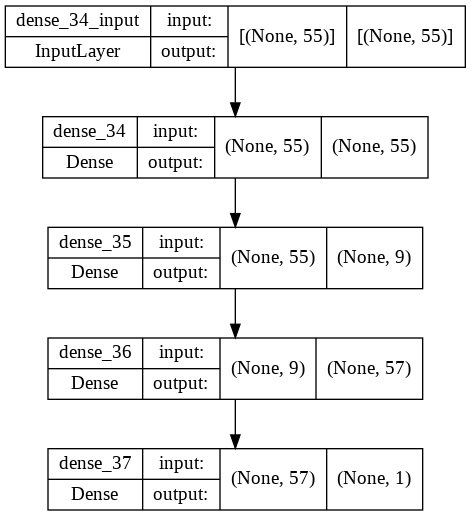

In [ ]:
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
plot_model(model, show_shapes=True, show_layer_names=True)

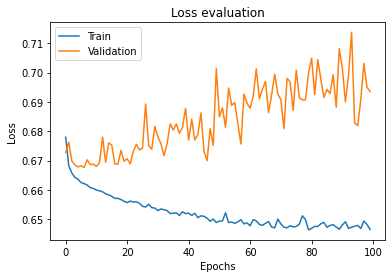

In [ ]:
# plot loss history function
def loss_plot(loss, val_loss):
  #plt.figure(figsize=(13,7))
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('Loss evaluation')
  plt.legend(['Train','Validation'])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
#  plt.show()

# loss history
loss_plot(history.history['loss'],
        history.history['val_loss'])

#plt.savefig("RNN residual loss eval.png")

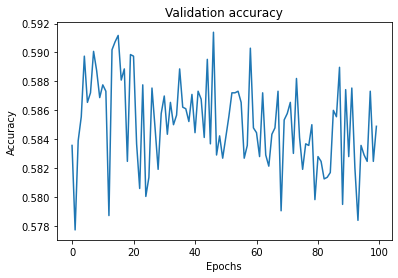

In [ ]:
# plot loss history function
def loss_plot(accuracy):
  #plt.figure(figsize=(13,7))
  plt.plot(accuracy)


  plt.title('Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
#  plt.show()

# loss history
loss_plot(history.history['val_accuracy'])


In [ ]:
# RMSE score
def predict_and_score(model, X, Y):
    pred = model.predict(X)
    orig_data = [Y]
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model, X_train, y_train)
rmse_test, test_predict = predict_and_score(model, X_test, y_test)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 0.48 RMSE
Test data score: 0.49 RMSE


In [ ]:
model.evaluate(X_train, y_train)

2551/2551 [==============================] - 4s 2ms/step - loss: 0.6680 - accuracy: 0.5879


[0.6679772734642029, 0.58790522813797]

In [ ]:
model.evaluate(X_test, y_test)

284/284 [==============================] - 0s 2ms/step - loss: 0.6738 - accuracy: 0.5783


[0.673806369304657, 0.5782800316810608]

cross validation

prediction

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score, plot_roc_curve

In [ ]:
# prediction
y_pred_test = (model.predict(X_test)>0.5).astype("int32")

In [ ]:
accuracy_score(y_test, y_pred_test)

0.5868798235942668

In [ ]:
# confusion matrix
confusion_matrix(y_test,y_pred_test)

array([[2496, 2149],
       [1598, 2827]])

In [ ]:
# confusion matrix
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.61      0.54      0.57      4645
           1       0.57      0.64      0.60      4425

    accuracy                           0.59      9070
   macro avg       0.59      0.59      0.59      9070
weighted avg       0.59      0.59      0.59      9070



In [ ]:
# ROC AUC
mlp_probs = model.predict(X_test)
roc_value = roc_auc_score(y_test, mlp_probs)
roc_value

0.6199014309779668

In [ ]:
!pip install scikit-plot

In [ ]:
model.predict(X_test)[:,:]

array([[0.5588038 ],
       [0.4681688 ],
       [0.26505977],
       ...,
       [0.45254207],
       [0.24178052],
       [0.5873008 ]], dtype=float32)

In [ ]:
proba=model.predict([X_test])

In [ ]:
probs = pd.DataFrame(model.predict(X_test))
probs[0]

0       0.558804
1       0.468169
2       0.265060
3       0.333523
4       0.520649
          ...   
9065    0.432756
9066    0.667046
9067    0.452542
9068    0.241781
9069    0.587301
Name: 0, Length: 9070, dtype: float32

In [ ]:
y_test

64977    1
71455    1
51349    1
16837    0
28319    1
        ..
12939    0
75794    0
37681    0
12964    0
57848    0
Name: churn, Length: 9070, dtype: int64

In [ ]:
skplt.metrics.plot_precision_recall_curve(y_test, probs)
plt.show()